In [42]:
using Plots
using StatsPlots
using JLD2
using MPSTime
using Random
using StatsBase
using Measures
using JSON

In [4]:

Xs_kepler_c4 =  JSON.parsefile("c4_folds_python.json")
# with open("../Folds/KEPLER/c6_folds_python.json") as f:
Xs_kepler_c6 = JSON.parsefile("c6_folds_python.json")
# Xs[fold][train/test][instance]




30-element Vector{Any}:
 Any[Any[Any[Any[-0.00805887866586219, -0.00205826478440785, 0.003577951801643, 0.00883457539905408, 0.0135254916471651, 0.0169217667193197, 0.0182694753789447, 0.0184228870512059, 0.0199606894127118, 0.0228721694941294  …  -0.0274406059327532, -0.0198103887804248, -0.0130506642349726, -0.00666897532086241, -0.000665343315095823, 0.00526577491703339, 0.0106024952796501, 0.0147453543251559, 0.017140005688039, 0.0177160163721599], Any[0.0277675457366054, 0.029310371063242, 0.0278639403278638, 0.013932863522039, -0.017970753773459, -0.0501032909752617, -0.0622863694311704, -0.0547668994605148, -0.0426210932239983, -0.0304685015724464  …  0.028932741150939, 0.028911302894968, 0.0273460250873243, 0.02821334227064, 0.0293811366387406, 0.0259063899935152, 0.00766663353896535, -0.0276593588217635, -0.0595617737651295, -0.0628156034590162], Any[0.0192225913189048, 0.0205674698270526, 0.02087898108192, 0.0215488297477447, 0.0230227860661975, 0.0233737134996757, 0.02629879

In [12]:
# # load imputation window indices
# with open("../Folds/KEPLER/kepler_windows_python_idx.json") as f:
# window_idxs_f = JSON.parsefile("kepler_windows_python_idx.json")
# window_idxs_kepler = {int(float(k)*100): v for k, v in window_idxs_f.items()}
# # print(window_idxs.keys())
# @load "kepler_windows_julia_idx.jld2"

In [13]:
windows_per_percentage

UndefVarError: UndefVarError: `windows_per_percentage` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [14]:
function get_vectors(fold, Xs)
    return stack(Xs[fold][1][1], dims=1), stack(Xs[fold][2][1], dims=1)
end

function trunc_fold(fold, Xs)
    tr, test = get_vectors(fold, Xs)
    ntrs = size(tr,1)
    ntest=size(test,1)

    return vcat(tr, test), [collect(1:ntrs), collect(ntrs+1:ntrs+ntest)]
end

function concat_folds(Xs)
    folds = Vector{Vector}(undef, length(Xs))
    Xs_full, folds[1] = trunc_fold(1, Xs)

    for fold in 2:length(Xs)
        Xs_f, inds_f = trunc_fold(fold, Xs)
        Xs_full = vcat(Xs_full, Xs_f)

        lind = folds[fold-1][end][end]
        folds[fold] = [inds_f[1] .+ lind, inds_f[2] .+ lind]

    end
    return Xs_full, folds
end

concat_folds (generic function with 1 method)

In [15]:
function get_vectors(fold, inst, Xs)
    return stack(Xs[fold][1][inst], dims=1), stack(Xs[fold][2][inst], dims=1)
end

function trunc_fold(fold, inst, Xs)
    tr, test = get_vectors(fold, Xs, inst)
    ntrs = size(tr,1)
    ntest=size(test,1)

    return vcat(tr, test), [collect(1:ntrs), collect(ntrs+1:ntrs+ntest)]
end

function concat_folds2(Xs)
    n_insts = length(Xs[1][1])
    folds = Vector{Vector}(undef, length(Xs))
    Xs_per_inst = Vector{Matrix{Float64}}(undef, n_insts)
    for inst in 1:n_insts
        Xs_full, folds[1] = trunc_fold(1, Xs, inst)
        
        for fold in 2:length(Xs)
            Xs_f, inds_f = trunc_fold(fold, Xs, inst)
            Xs_full = vcat(Xs_full, Xs_f)

            lind = folds[fold-1][end][end]
            folds[fold] = [inds_f[1] .+ lind, inds_f[2] .+ lind]

        end
        Xs_per_inst[inst] = Xs_full
    end
    # folds will always be the same so nothing special goes on there
    return Xs_per_inst, folds
end

concat_folds2 (generic function with 1 method)

In [ ]:
function get_vectors(fold, inst, Xs)
    return stack(Xs[fold][1][inst], dims=1), stack(Xs[fold][2][inst], dims=1)
end

function trunc_fold(fold, inst, Xs)
    tr, test = get_vectors(fold, Xs, inst)
    ntrs = size(tr,1)
    ntest=size(test,1)

    return vcat(tr, test), [collect(1:ntrs), collect(ntrs+1:ntrs+ntest)]
end

function concat_folds2(Xs)
    n_insts = length(Xs[1][1])
    folds = Vector{Vector}(undef, length(Xs))
    Xs_per_inst = Vector{Matrix{Float64}}(undef, n_insts)
    for inst in 1:n_insts
        Xs_full, folds[1] = trunc_fold(1, Xs, inst)
        
        for fold in 2:length(Xs)
            Xs_f, inds_f = trunc_fold(fold, Xs, inst)
            Xs_full = vcat(Xs_full, Xs_f)

            lind = folds[fold-1][end][end]
            folds[fold] = [inds_f[1] .+ lind, inds_f[2] .+ lind]

        end
        Xs_per_inst[inst] = Xs_full
    end
    # folds will always be the same so nothing special goes on there
    return Xs_per_inst, folds
end

In [88]:
function invert_fold(f1_tr, f1_te, fk_tr, fk_te)
    p1 = sortperm(eachrow(vcat(f1_tr, f1_te)))
    pk = sortperm(eachrow(vcat(fk_tr, fk_te)))
    pki = invperm(pk)

    fold_order = p1[pki]
    n_test = size(fk_te, 1)

    return fold_order[1:end-n_test], fold_order[end-n_test+1:end]
end


function concat_folds3(Xs)
    n_insts = length(Xs[1][1])
    folds = [Vector{Vector{Vector{Int}}}(undef, length(Xs)) for _ in 1:n_insts]
    Xs_per_inst = Vector{Matrix{Float64}}(undef, n_insts)
    for inst in 1:n_insts
        Xs_full, fold = trunc_fold(1, Xs, inst)
        folds[inst][1] = fold
        f0_tr, f0_te = Xs_full[fold[1], :], Xs_full[fold[2], :]
        
        for fold in 2:length(Xs)
            inds_tr, inds_te = invert_fold(f0_tr, f0_te, get_vectors(fold, inst, Xs)...)
            folds[inst][fold] = [inds_tr, inds_te]
        end
        Xs_per_inst[inst] = Xs_full
    end
    # folds will always be the same so nothing special goes on there
    return Xs_per_inst, folds
end

concat_folds3 (generic function with 1 method)

In [92]:
# Xs_1::Matrix{Float64}, folds_1 = concat_folds(Xs_kepler_c6)
Xs_per_inst, folds = concat_folds3(Xs_kepler_c6)
Xs_per_inst_old, folds_old = concat_folds2(Xs_kepler_c6)

@save "c6_folds_per_inst.jld2" Xs_per_inst folds

# Xs_2::Matrix{Float64}, folds_2 = concat_folds(Xs_kepler_c4)
# Xs_per_inst, folds = concat_folds3(Xs_kepler_c4)
# Xs_per_inst_old, folds_old = concat_folds2(Xs_kepler_c4)


@save "c4_folds_per_inst.jld2" Xs_per_inst folds

In [90]:
eq = true
for inst in eachindex(Xs_per_inst)
    for fold in eachindex(folds)
        tr_1, te_1 = Xs_per_inst[inst][folds[inst][fold][1],:], Xs_per_inst[inst][folds[inst][fold][2],:]
        tr_2, te_2 = Xs_per_inst_old[inst][folds_old[fold][1],:], Xs_per_inst_old[inst][folds_old[fold][2],:]
        eq &= isapprox(tr_1,tr_2) && isapprox(te_1, te_2)

    end
end
eq

true

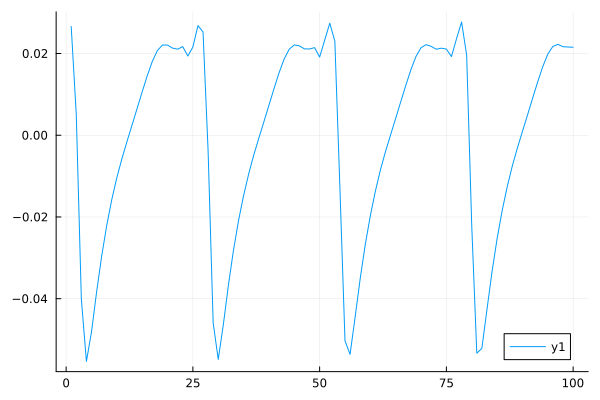

In [81]:
plot(te_1[1,:])

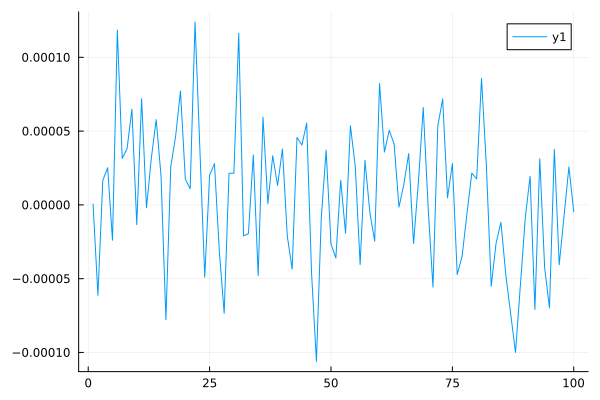

In [22]:
plot(Xs_per_inst[20][40,:])

In [33]:
any(ismissing.(stack(stack(Xs_kepler_c4[:][1][1]))))
# 


false

In [25]:
eq = true
for f in 1:length(folds)
    tr_inds, te_inds = folds[f]
    eq &= [c == Xs_kepler_c4[f][2][1][i] for (i,c) in enumerate( eachrow(Xs[te_inds, :]))] |> all
end

eq

true

In [26]:
max_val = maximum(maximum(vcat(vcat(Xs_kepler_c4[1][1][1], Xs_kepler_c4[1][2][1])'...), dims=2))
min_val = minimum(minimum(vcat(vcat(Xs_kepler_c4[1][1][1], Xs_kepler_c4[1][2][1])'...), dims=2))
r = max_val - min_val

0.0002060463509944157

In [ ]:
vcat(Xs)

43×100 Matrix{Any}:
 -0.00805888   -0.00205826    0.00357795   …   0.01714      0.017716
  0.0277675     0.0293104     0.0278639       -0.0595618   -0.0628156
  0.0192226     0.0205675     0.020879         0.0243126    0.02654
 -0.0115206    -0.00549222    0.000237925      0.0168181    0.0182477
 -0.00457488    0.000926216   0.00597996       0.0169821    0.0173674
  0.00317329    0.00840522    0.0129262    …   0.0205697    0.0218516
  0.0217425     0.0230014     0.0235284        0.0250563    0.0265118
 -0.0319918    -0.0464448    -0.0502075       -0.0222939   -0.0147024
  0.00659351    0.0122858     0.0171395        0.0273546    0.0285027
 -0.00455219    0.003447      0.00896063       0.022006     0.0240125
  ⋮                                        ⋱               
 -0.000215543   0.00543131    0.0105752        0.021244     0.0224311
 -0.0207654    -0.0136697    -0.00721348   …   0.0114896    0.0160719
 -0.0559976    -0.0444561    -0.0324958       -0.0056726    0.000616657
 -0.0235817